<h1 style="text-align: center;">Логистическая регрессия и регуляризация.</h1>

---

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
np.random.seed(42)

### Градиентный спуск

Рассмотрим функцию от двух переменных
$f(x, y) = \sin^2 x + \sin^2 y$

In [15]:
def f(x):
    return np.sum(np.power(np.sin(x)**2, 2))

Здесь $x$ - numpy-array вектор длины 2.

In [9]:
def grad_f(x):
    return 2 * np.sin(x) * np.cos(x)

In [13]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    if x0 is None:
        x0 = np.random.random(2)
    history = []

    curr_x = x0.copy()
    for i in range(num_iter):
        history.append(np.hstack((curr_x, f(curr_x))))
        curr_x -= lr * grad_f(curr_x)

    return np.vstack(history)

### Тестируем написанную функцию

In [16]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $x_1, x_2, f(x_1, x_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму.

(Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_x_1, cur\_x_2, f(cur\_x_1, cur\_x_2)$ в `steps` в процессе спуска)

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точку минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

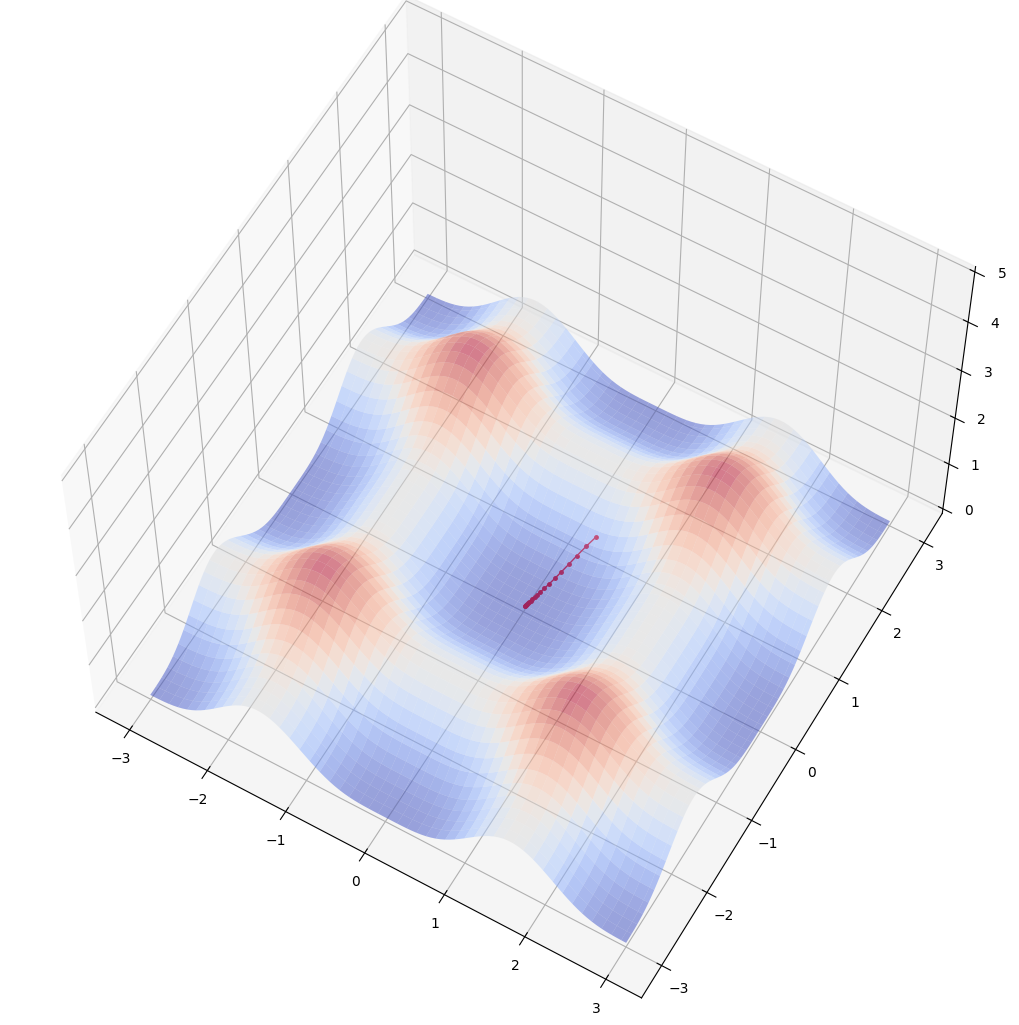

In [46]:
# %matplotlib osx

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

path = []

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
Z = np.array([f(np.array([x,y])) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)


fig = plt.figure(figsize=(16, 10))
ax = Axes3D(fig)
fig.add_axes(ax)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.5)

ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
        marker='.', color='red', linewidth=1, markersize=5)

ax.set_zlim(0, 5)
ax.view_init(elev=60)
plt.show()

Посмотрим на график значений функции от шага

In [ ]:
plt.figure(figsize=(14,7))
plt.xlabel('grad descent step number')
plt.ylabel('$f(x)$')
plt.title('Значение функции на каждом шаге гардиентного спуска.')

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label='gradient descent result')
plt.legend()

Когда вы используете градиентный спуск всегда нужно проверять, сошелся ли он. К сожалению для большинства моделей не получится построить 3D график, поэтому обязательно нужно смотреть на то, как менялся лосс на каждом шаге градиентного спуска.

# Генератор батчей

Обычно генерация батчей отличается от той, которую мы использовали в семинаре. Мы выбирали *batch_size* случайных строчек на каждом шаге, но у такого подхода есть минусы. Основной заключается в том, что некоторые строчки из обучающего датасета могут попадаться значительно реже, чем другие.

Чтобы это исправить обучение делят на эпохи. Мы хотим, чтобы в течение одной эпохи модель обучилась на каждом примере один раз. Для этого нужно перемешать строчки в датасете и каждый раз брать очередные *batch_size* строчек.

Может так получится, что размер датасета не делится на *batch_size*, тогда последний батч будет состоять из нескольких последних строк и его размер будет меньше, чем *batch_size*. Такой батч иногда выкидывают и просто не используют. Именно так вам нужно поступить в этом задании.

## Задание 2

Напишите генератор батчей, который будет принимать на вход признаки, ответы и размер батча. Генератор должен возвращать tuple из ($X_{batch}$, $y_{batch}$). Если размер датасета не делится на batch_size, то **последний маленький батч возвращать не нужно**.

Подробнее про Python генераторы можно прочитать здесь:

[Документация](https://wiki.python.org/moin/Generators)

[Описание на русском](https://pythoner.name/list-generator)

Чтобы не перемешивать сам датасет воспользуйтесь np.random.permutation(len(X))


In [ ]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] --- матрица объекты-признаки
    param y: np.array[n_objects] --- вектор целевых переменных
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    for batch_start in <YOUR CODE>:
        #YOUR CODE
        yield #YOUR CODE

### Тестируем написанную функцию

Проверим, что наш генератор батчей перемешивает датасет и каждый элемент встречается один раз:

In [ ]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), "Что-то не так!"
assert (y_fake != y_reconstructed).all(), "Что-то не так!"

assert (np.sort(X_reconstructed, axis=0) == X_fake).all(), "Что-то не так!"

Попробуем теперь *batch_size* не делящий размер датасета.

In [ ]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7, "Что-то не так!"

# Обычная логистическая регрессия
В этом пункте вы напишете класс логистической регрессии. Пока мы не будем добавлять в функцию потерь регуляризационные слагаемые.

Вам необходимо будет воспользоваться оптимизацией с помощью SGD, используя генератор батчей, который вы написали выше.

## Задание 3
Реализуйте методы ``fit`` и ``get_grad`` класса ``MyLogisticRegression``.


Напоминаем формулы:

$$Loss(y, p) = -\sum_{i=1}^{\ell} (y_i \log (p_i) + (1 - y_i) \log (1 - p_i))$$


$$ \frac{\partial L}{\partial w} = X^T (p - y)$$


In [ ]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [ ]:
class MyLogisticRegression(object):
    def __init__(self):
        self.w = None

    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        l, n = X.shape
        if self.w is None:
            np.random.seed(42)
            # Вектор столбец в качестве весов
            self.w = np.random.randn(n + 1)

        X_train = np.concatenate((np.ones((l, 1)), X), axis=1)

        losses = []

        # Положите в лист losses лосс на каждом батче. Не нужно усреднять лосс по эпохе.

        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):
                #В X_train уже добавлен вектор 1

                predictions = #YOUR CODE: предскажите вероятности на X_batch
                loss = #YOUR CODE: вычислите loss на текущем батче

                assert (np.array(loss).shape == tuple()), "Лосс должен быть скаляром!"

                losses.append(<YOUR CODE>)

                #YOUR CODE: обновите self.w по формуле градиентного спуска. Используйте функцию self.get_grad для вычисления градиента. Не забудьте про learning rate!

        return losses

    def get_grad(self, X_batch, y_batch, predictions):
        """

        param X_batch: np.array[batch_size, n_features + 1] --- матрица объекты-признаки
        param y_batch: np.array[batch_size] --- батч целевых переменных
        param predictions: np.array[batch_size] --- батч вероятностей классов

        Принимает на вход X_batch с уже добавленной колонкой единиц.
        Выдаёт градиент функции потерь в логистической регрессии
        как сумму градиентов функции потерь на всех объектах батча
        ВНИМАНИЕ! Нулевая координата вектора весов -- это BIAS, а не вес признака.
        Также не нужно ДЕЛИТЬ ГРАДИЕНТ НА РАЗМЕР БАТЧА:
        нас интересует не среднее, а сумма.
        В качестве оператора умножения матриц можно использовать @

        Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])
        """

        # компонент градиента из логрегрессии
        # следите за размерностями

        grad_basic = #YOUR CODE
        assert grad_basic.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic

    def predict_proba(self, X):
        l, n = X.shape
        X_ = np.concatenate((np.ones((l, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def _predict_proba_internal(self, X):
        """
        Возможно, вы захотите использовать эту функцию вместо predict_proba, поскольку
        predict_proba конкатенирует вход с вектором из единиц, что не всегда удобно
        для внутренней логики вашей программы
        """
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def get_weights(self):
        return self.w.copy()
        # copy тут используется неспроста. Если copy не использовать, то get_weights()
        # выдаст ссылку на объект, а, значит, модифицируя результат применения функции
        # get_weights(), вы модифицируете и веса self.w. Если вы хотите модифицировать веса,
        # (например, в fit), используйте self.w

    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

### Тестируем написанную функцию


In [ ]:
m = MyLogisticRegression()
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.22, -3.2 , -0.93])), "Что-то не так!"

In [ ]:
np.random.seed(42)
m = MyLogisticRegression()
X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "Что-то не так!"

# Логистическая регрессия с $l_1$ и $l_2$ регуляризацией (elastic net).

Ваша задача -- написать класс логистической регрессии с обеими регуляризациями и оптимизацией с помощью SGD, используя генератор батчей, который вы написали выше.

Обратите внимание, что реализация ElasticNet отличается от реализации LogisticRegression только функцией потерь для оптимизации. Поэтому единственная функция, которая будет отличаться у двух методов, это ``self.get_grad()``.

Поэтому в данном случае естественно применить паттерн *наследования*. Весь синтаксис наследования мы прописали за вас. Единственное, что вам осталось сделать, это переопределить метод ``get_grad()`` в отнаследованном классе.

## Задание 4
Реализуйте метод ``get_grad()`` класса ``MyElasticLogisticRegression``

Формулы:

$$L_1 (w) = \alpha \sum_{j=1}^{n}|w_j| $$

$$L_2 (w) = \beta\sum_{j=1}^{n}w_j^2$$

$$\frac{\partial L_1}{\partial w_1} = \alpha \cdot \mathrm{sign}(w_1)$$

$$ \frac{\partial L_2}{\partial w_1} = 2\beta w_1$$


In [ ]:
class MyElasticLogisticRegression(MyLogisticRegression):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None

    def get_grad(self, X_batch, y_batch, predictions):
        """
        Принимает на вход X_batch с уже добавленной колонкой единиц.
        Выдаёт градиент функции потерь в логистической регрессии с регуляризаторами
        как сумму градиентов функции потерь на всех объектах батча + регуляризационное слагаемое
        ВНИМАНИЕ! Нулевая координата вектора весов -- это BIAS, а не вес признака.
        Bias в регуляризационные слагаемые не входит. Также не нужно ДЕЛИТЬ ГРАДИЕНТ НА РАЗМЕР БАТЧА:
        нас интересует не среднее, а сумма.

        Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])
        """


        grad_basic = #YOUR CODE: компонент градиента из логрегрессии. Обнулять bias-компоненту этой составляющей градиента не нужно!

        grad_l1 = #YOUR CODE: компонент градиента из l_1-регуляризации (не забудьте обнулить компоненту с bias)
        grad_l2 = #YOUR CODE: компонент градиента из l_2-регуляризации (не забудьте обнулить компоненту с bias)

        # Обнулять bias-компоненту вектора весов не нужно!

        assert grad_l1[0] == grad_l2[0] == 0, "Bias в регуляризационные слагаемые не входит!"
        assert grad_basic.shape == grad_l1.shape == grad_l2.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic + grad_l1 + grad_l2

### Тестирование
Протестируем написанную функцию:


In [ ]:
m = MyElasticLogisticRegression(.2,.2)
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.82, -2.6 , -0.33])), "Что-то не так!"


In [ ]:
np.random.seed(42)
m = MyElasticLogisticRegression(.2, .2)
X = np.random.rand(100,3)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([49.11489408, 24.4698149, 25.87049356, 25.0139452])), "Что-то не так!"


## Смотрим, как работает наша модель
Протестируем на искусственных данных:

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)
#y = y.reshape(-1, 1)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [ ]:
clf = MyElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

In [ ]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

Теперь протестируем на датасете MNIST. Это очень простой класический датасет, на котором часто тестируются модели. С помощью нейронных сетей люди научились получать на нем качество 99.84%.

Датасет состоит из черно-белых картинок с цифрами. ![mnist-3.0.1.png](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Так как мы сделали классификатор для двух классов, то мы выберем из всех картинок только картинки 0 и 1, првратим их из двумерной матрицы в вектор и обучим нашу модель.

In [ ]:
data = pd.read_csv('./train.csv')
#файл лежит в директории с домашним заданием. Чтобы иметь возможность его
#открыть, загрузите его на колаб (панель слева, нажимаем значок "Файлы",
#выбираем "загрузить в сессионное хранилище", выбираем нужный файл)
data.head()

Данные выглядят как таблица, первая колонка которой это лейбел -- цифра, которая изображена на картинке, а следующие 784 колонки это значения от 0 до 255, описывающие все пиксели картинки 28х28. То есть нам не придется делать reshape и превращать матрицу в вектор, так как это уже сделано.

In [ ]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# Выберем только картинки, где изображен 0 и 1
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

Для оценки модели мы используем кросс валидацию.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# YOUR CODE
# Сделайте sklearn pipeline с StandarScaler и MyElasticLogisticRegression и проверьте точность с помощью cross_val_score.
# в качестве scorer используйте 'accuracy'. Эта часть не проверяется в степике.


print(f"Mean accuracy of Logistic Regression for two classes is {mean_accuracy}")